### In this notebook I will do the following:

* Train SetFit with random sampling and hard negative sampling using the SST2 dataset from huggingface and 50 examples per class.
* Compare the performance of random sampling against hard negative sampling on the test set.
* Plot the first 2 principal components of the embeddings of the test set and compare the generated embeddings using random sampling against embeddings generated using hard negative sampling.

In [8]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation, util
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from setfit import SetFitModel, SetFitTrainer
from sentence_transformers.losses import CosineSimilarityLoss
from matplotlib import pyplot as plt
from warnings import simplefilter
import math
import pandas as pd
import numpy as np
from tqdm import tqdm
from helper_functions import get_data, preprocess_ade_sent
from datasets import load_dataset
simplefilter(action='ignore', category=FutureWarning)



In [2]:
# SetFit - Hard negative/positive sampling

def select_pairs(idx_to_cossim_pos, idx_to_cossim_neg, current_sentence, sentences, pairs):
    # select the example from the same class
    second_idx = min(idx_to_cossim_pos, key=idx_to_cossim_pos.get)
    # Prepare a positive pair and update the sentences and labels lists, respectively
    positive_sentence = sentences[second_idx]
    pairs.append(InputExample(texts=[current_sentence, positive_sentence], label=1.0))

    # select the example from the other class
    third_idx = max(idx_to_cossim_neg, key=idx_to_cossim_neg.get)
    # Prepare a negative pair and update the sentences and labels lists, respectively
    negative_sentence = sentences[third_idx]
    pairs.append(InputExample(texts=[current_sentence, negative_sentence], label=0.0))

    # remove the selected indeces to avoid selecting the same sentences for a given sentence
    idx_to_cossim_pos.pop(second_idx)
    idx_to_cossim_neg.pop(third_idx)
    return (pairs)


def sentence_pairs_generation(sent_idx, sentences, labels, embeddings, pairs, num_itr):
    # get the unique labels 
    num_classes = np.unique(labels)
    # if needed, convert the labels into numerical representations (0 and 1)
    #label_to_idx = {x: i for i, x in enumerate(num_classes)}  

    # get the indexes of positive and negative examples
    negative_idxs = np.where(labels == num_classes[0])[0]
    positive_idxs = np.where(labels == num_classes[1])[0]

    # create a dictionary to store for the cosine similarities between a given sentence and all sentences of positive or negative class
    idx_to_cossim_pos = {}
    for idx_pos, embed in zip(positive_idxs, embeddings[positive_idxs]):
        cossim_value = util.pytorch_cos_sim(embeddings[sent_idx], embed)
        idx_to_cossim_pos[idx_pos] = cossim_value

    idx_to_cossim_neg = {}
    for idx_pos, embed in zip(negative_idxs, embeddings[negative_idxs]):
        cossim_value = util.pytorch_cos_sim(embeddings[sent_idx], embed)
        idx_to_cossim_neg[idx_pos] = cossim_value

    # for each iteration and for a given sentence, we build 2 pairs where each pair includes the sentence itself and the selected sentence from the same class or the selected sentence from other class
    for _ in range(num_itr):
        # get the current sentence
        current_sentence = sentences[sent_idx]
        label = labels[sent_idx]

        # build the 2 pairs for the current sentence and add to the training examples
        if label == num_classes[1]: # positive example
            pairs = select_pairs(idx_to_cossim_pos, idx_to_cossim_neg, current_sentence, sentences, pairs)

        elif label == num_classes[0]: # negative example
            pairs = select_pairs(idx_to_cossim_neg, idx_to_cossim_pos, current_sentence, sentences, pairs)

    return (pairs)


def generate_sentence_pairs(sentences, labels, embeddings, num_itr):  
    train_examples = [] 
    for sent_idx in range(len(sentences)):  
        train_examples = sentence_pairs_generation(sent_idx, np.array(sentences), np.array(labels), embeddings, train_examples, num_itr)
    return train_examples


def finetune_st_logreg(model_name, train_df, test_df, num_iterations=20):   
    # get the sentences and labels from the training and test dataset
    train_sentences = train_df['text']
    train_labels = train_df['label']
    test_sentences = test_df['text']
    test_labels = test_df['label']
    
    # generate the pre-trained sentence embeddings for the training sentences from ST
    st_model = SentenceTransformer(model_name)
    train_embeddings = st_model.encode(train_sentences)
    # generate the sentence pairs which are needed for fine-tune the ST pre-trained embeddings
    train_examples = generate_sentence_pairs(train_sentences, train_labels, train_embeddings, num_iterations)
    
    # fine-tune ST pre-trained sentence embeddings
    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
    train_loss = losses.CosineSimilarityLoss(st_model)
    st_model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=math.ceil(len(train_dataloader) * 0.1),
              show_progress_bar=True, optimizer_params={"lr": 2e-5})
    
    # encode the training and test sentences using the fine-tuned model
    finetuned_train_embeddings = st_model.encode(train_sentences)
    finedtuned_test_embeddings = st_model.encode(test_sentences)
    # train a Logistic Regression using the fine-tuned training embeddings
    logreg_model = LogisticRegression()
    logreg_model.fit(finetuned_train_embeddings, train_labels)
    
    # evaluate the model performance on test dataset using accuracy
    acc_score = accuracy_score(test_labels, logreg_model.predict(finedtuned_test_embeddings))
    return st_model, logreg_model, acc_score

In [3]:
# SetFit - Random sampling

def train_setfit(model_name, train_data, eval_data, num_iterations=20, column_mapping=None): 
    """
        Fine-Tuning of SetFit
    """
    model = SetFitModel.from_pretrained(model_name)

  # Create trainer
    trainer = SetFitTrainer(
          model=model,
          train_dataset=train_data,
          eval_dataset=eval_data,
          loss_class=CosineSimilarityLoss,
          batch_size=16,
          num_iterations=num_iterations, # Number of text pairs to generate for contrastive learning
          num_epochs=1, # Number of epochs to use for contrastive learning,
          column_mapping=column_mapping
      )

    trainer.train()
    metrics = trainer.evaluate()
    return trainer, metrics['accuracy']

* Write function to plot the fine-tuned embeddings generated using random and hard negative sampling


In [15]:

def plot(random_embeddings, hn_embeddings, labels):
    plt.figure(figsize=(20,10))

    tsne_random_embeddings = TSNE(n_components=2, random_state=42).fit_transform(random_embeddings)
    plt.subplot(221)
    plt.title(f'SST2 X_test Random Sampling')

    for i, t in enumerate(set(np.array(labels))):
        idx = labels == t
        plt.scatter(tsne_random_embeddings[idx, 0], tsne_random_embeddings[idx, 1], label=t)   

    plt.legend(bbox_to_anchor=(1, 1));
    
    tsne_hn_embeddings = TSNE(n_components=2, random_state=42).fit_transform(hn_embeddings)
    plt.subplot(222)
    plt.title(f'SST2 X_test Hard Negative Sampling')

    for i, t in enumerate(set(np.array(labels))):
        idx = labels == t
        plt.scatter(tsne_hn_embeddings[idx, 0], tsne_hn_embeddings[idx, 1], label=t)   

    plt.legend(bbox_to_anchor=(1, 1));

* Preprocess the datasets for training SetFit


In [4]:

ade_df = load_dataset('SetFit/ade_corpus_v2_classification')
sent_df = load_dataset('SetFit/SentEval-CR')
ade_df, sent_df = preprocess_ade_sent(ade_df, sent_df)
sst2_df = load_dataset('SetFit/sst2')

dataset_dic = {'SST2' : sst2_df, 
               'ADE' : ade_df,
               'SENT' : sent_df}

Found cached dataset json (C:/Users/loriz/.cache/huggingface/datasets/SetFit___json/SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/2 [00:00<?, ?it/s]

Found cached dataset json (C:/Users/loriz/.cache/huggingface/datasets/SetFit___json/SetFit--SentEval-CR-c9aa0d3185fe82a0/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-1f1a8a830610b25b.arrow
Found cached dataset json (C:/Users/loriz/.cache/huggingface/datasets/SetFit___json/SetFit--SentEval-CR-c9aa0d3185fe82a0/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--ade_corpus_v2_classification-dc9f56b8a6e529e5\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-37c62335d496ce95.arrow
Found cached dataset json (C:/Users/loriz/.cache/huggingface/datasets/SetFit___json/SetFit--sst2-67a650649f1843ed/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/3 [00:00<?, ?it/s]

* Train SetFit using hard negative sampling


In [6]:

model_name = 'all-mpnet-base-v2'
train_df, test_df = get_data(dataset_dic['SST2'], seed=42, nr_example_per_class=50)
st_model_hn, logreg_model_hn, acc_score_hn = finetune_st_logreg('sentence-transformers/' + model_name, train_df, test_df, 10)

Loading cached shuffled indices for dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--sst2-67a650649f1843ed\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-59b1bab50a0e2eff.arrow
Loading cached processed dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--sst2-67a650649f1843ed\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-ec35821b80ca2a1c.arrow
Loading cached shuffled indices for dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--sst2-67a650649f1843ed\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-59b1bab50a0e2eff.arrow
Loading cached processed dataset at C:\Users\loriz\.cache\huggingface\datasets\SetFit___json\SetFit--sst2-67a650649f1843ed\0.0.0\e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4\cache-2a32d07e4ccf764e.arrow
Loading cached shuffled indices for dataset at C:\Users\loriz\.cache\huggingface\datas

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/125 [00:00<?, ?it/s]

* Train SetFit using random sampling


In [9]:

trainer_random, acc_score_random = train_setfit('sentence-transformers/' + model_name, train_df, test_df, 10)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Generating Training Pairs:   0%|          | 0/10 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 2000
  Num epochs = 1
  Total optimization steps = 125
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/125 [00:00<?, ?it/s]

***** Running evaluation *****


In [12]:
print(f'Accuracy Random Sampling: {acc_score_random}')
print(f'Accuracy Hard Negative Sampling: {acc_score_hn}')

Accuracy Random Sampling: 0.8879736408566722
Accuracy Hard Negative Sampling: 0.9049972542559034


* Encode the test embeddings using the fine tuned SetFit model with random sampling and the fine tuned SetFit model using hard negative sampling

In [13]:
test_embeddings_random = trainer_random.model.model_body.encode(test_df['text'])
test_embeddings_hn = st_model_hn.encode(test_df['text'])

* Plot the first 2 principal components of test embeddings generated using random sampling and hard negative sampling 

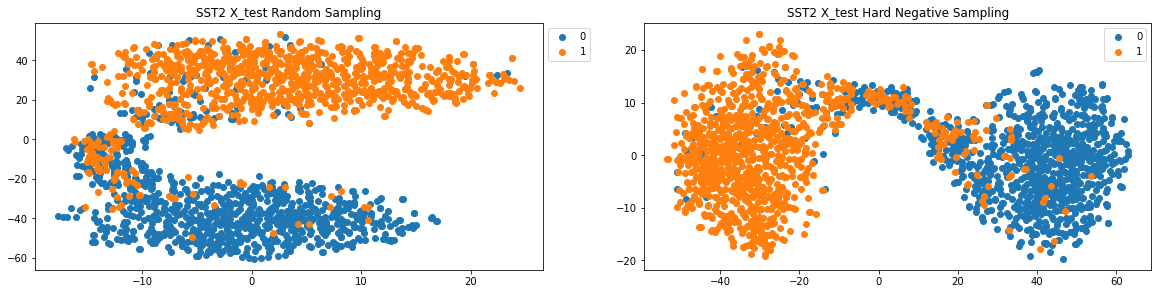

In [16]:
plot(random_embeddings=test_embeddings_random, hn_embeddings=test_embeddings_hn, labels=test_df['label'])